In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


data = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data.head()

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,price_dex,tcost_usd,time,time_dex,price_cex,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm
0,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2280.878682,13.245562,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898
1,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2280.878682,10.235724,2024-01-01 00:00:23,2024-01-01 00:00:23,2281.19,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399
2,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2281.106770,6.410172,2024-01-01 00:00:47,2024-01-01 00:00:47,2282.69,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,19.908921
3,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2281.106770,6.936970,2024-01-01 00:00:59,2024-01-01 00:00:59,2282.69,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,20.441538
4,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2281.106770,88.043187,2024-01-01 00:01:23,2024-01-01 00:01:23,2281.64,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,20.481472


In [2]:
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)

data['LVR_nbtoken']     = data['LVR']/data['price_dex']

data['avg_gas'] = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']

data['arb_fee']    = (np.abs(data['LVR_clean'] * data['amountUSD']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['LVR']) #.clip(-3, 3)


data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['volumeUSD']       = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = data['price_dex'].pct_change(1).shift(-1)*100

data['time_diff']           = data['time'].diff().dt.total_seconds().fillna(0)
data['rolling_time_span']   = data['time_diff'].rolling(window=3600, min_periods=1).sum()
data['rolling_trade_count'] = data['time'].rolling(window=3600, min_periods=1).count()
data['lambda'] = data['rolling_trade_count'] / data['rolling_time_span']
data['lambda'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff']) # , 'rolling_time_span', 'rolling_trade_count'])


data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,arb_fee,LVR_zscore,std,mean_rol_amount,volumeUSD,price_impact,rolling_time_span,rolling_trade_count,lambda,target_fee
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,87.938205,-0.009924,4.766625,31043.984573,3.267411e+06,0.000000,1404.0,100.0,0.071225,-0.706110
98,-6808.589388,2.969865,6803.265430,0xf9f12a0370a11ab1cfbb6377040a0e374ae78aa8,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,609606,1.225569e+10,1.225569e-08,...,80.566347,-0.007812,4.713025,31469.253010,3.256138e+06,0.000000,1404.0,101.0,0.071937,-0.667191
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,18.581544,-0.009979,4.655251,31203.846347,3.255538e+06,0.010000,1428.0,102.0,0.071429,-0.183706
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,75.997578,-0.010422,4.599576,20749.062023,3.232065e+06,0.000000,1476.0,103.0,0.069783,0.641063
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,76.959780,-0.009811,4.539570,20425.349686,3.231848e+06,0.000000,1500.0,104.0,0.069333,-0.646696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59994,-3609.600145,1.400000,3614.875537,0x09377b785178a3dfe548328123604668b51105a0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704932e+09,256486,5.365090e+10,5.365090e-08,...,263.589823,-0.013316,7.560117,38569.517075,6.724532e+06,0.000000,32388.0,3600.0,0.111152,-0.989784
59995,-2062.694719,0.800000,2065.676196,0xca74f404e0c7bfa35b13b511097df966d5a65597,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.704932e+09,403756,5.626490e+10,5.626490e-08,...,264.090129,-0.011884,7.507411,38686.836319,6.724595e+06,0.000000,32388.0,3600.0,0.111152,-0.989885
59996,-3953.442238,1.533426,3959.304818,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x475d2c6f6a46a83d1781e61500d1c540f85fd721,1.704932e+09,248525,5.216118e+10,5.216118e-08,...,242.561274,-0.013343,7.453936,38555.229368,6.662888e+06,-0.019997,32388.0,3600.0,0.111152,-0.984484
59997,-9584.192801,3.717716,9598.772684,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xeef68d213fbbf6f01235a6c1318f82a1692c01de,1.704932e+09,341150,4.985426e+10,4.985426e-08,...,121.849365,-0.014075,7.403159,38889.495677,6.668813e+06,0.060015,32400.0,3600.0,0.111111,-0.839209


In [23]:
features = ['LVR_nbtoken', 'LVR', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'volumeUSD', 'lambda',  'rolling_time_span', 'amountUSD']
target = 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error (Test): {mse_test:.3f}")

feature_importances = model.feature_importances_
normalized_feature_importances = feature_importances / feature_importances.sum()

features_importance_normalized = {feature: importance for feature, importance in zip(features, normalized_feature_importances)}
print("\nNormalized Feature Importances:")
for feature, importance in features_importance_normalized.items():
    print(f"{feature}: {importance:.4f}")


Mean Squared Error (Test): 2333.250

Normalized Feature Importances:
LVR_nbtoken: 0.0494
LVR: 0.0731
std: 0.2242
mean_rol_amount: 0.0948
avg_gas: 0.2371
price_impact: 0.0156
volumeUSD: 0.1507
lambda: 0.0527
rolling_time_span: 0.0499
amountUSD: 0.0523


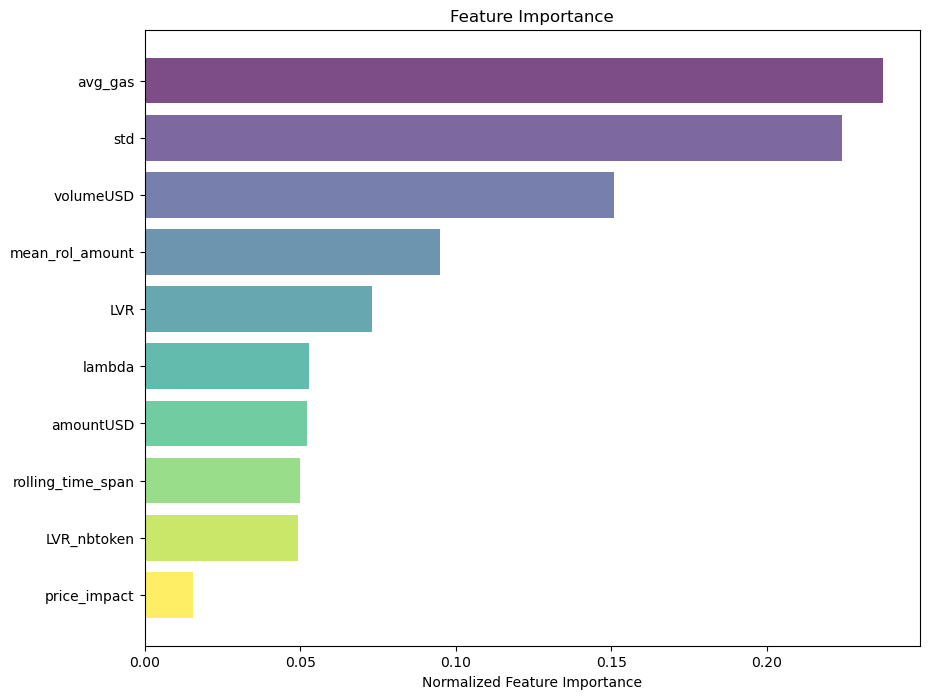

In [63]:
features = list(features_importance_normalized.keys())
importances = list(features_importance_normalized.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Use viridis color map
colors = plt.cm.viridis(np.linspace(1, 0, len(features)))

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color=colors, alpha=0.7)
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance')
plt.show()


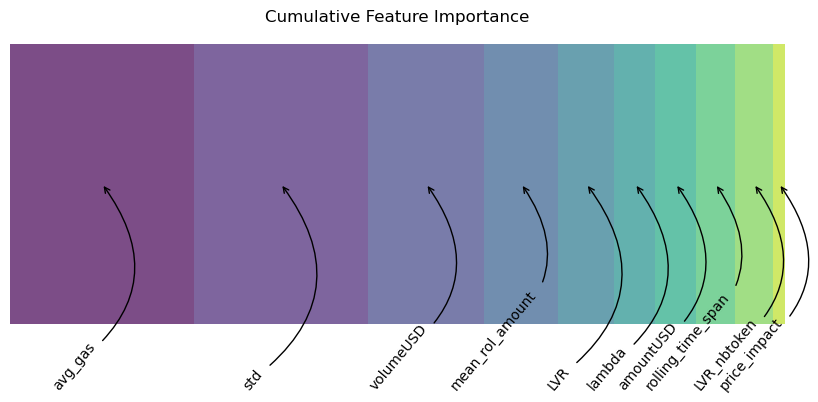

In [52]:
import matplotlib.pyplot as plt

# Assuming 'features_importance_normalized' is your dictionary with your features and their normalized importances
features = list(features_importance_normalized.keys())
importances = list(features_importance_normalized.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plot setup
plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
cumulative_importances = [sum(sorted_importances[:i+1]) for i in range(len(sorted_importances))]
starts = [0] + cumulative_importances[:-1]  # Starting point for each feature's bar section

# Create a stacked bar plot with annotations
for i, feature in enumerate(sorted_features):
    plt.barh(' ', sorted_importances[i], left=starts[i], color=plt.cm.viridis(i / len(sorted_features)), alpha=0.7)
    # Annotate each bar section with the feature name
    plt.annotate(feature, 
                 xy=(starts[i] + sorted_importances[i] / 2, 0), 
                 xytext=(-20, -150),  # Adjust as needed
                 textcoords="offset points",
                 ha='center', va='bottom',
                 rotation=50,  # Adjust as needed
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"))

plt.xlabel('Normalized Feature Importance')
plt.title('Cumulative Feature Importance')
plt.xlim(0, 1)  # Ensure the x-axis goes from 0 to 1 to represent the full 100% of importances
plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()


In [51]:
f_min = 0.01
f_max = 0.1
w     = 0.04
x0 = (f_max-f_min)/(2*w)  # Adjust x0 as needed based on your understanding of the data
k = 1.75  # Steepness of the curve

buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:    
    # here for each features the parameters of the sigmoid will be the one to calibrate
    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k, x0))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k, x0))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)
combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']


In [64]:
# check the fee is correctly computed for each features
combined_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,std_weighted_fee,mean_rol_amount_weighted_fee,avg_gas_weighted_fee,price_impact_weighted_fee,volumeUSD_weighted_fee,lambda_weighted_fee,rolling_time_span_weighted_fee,amountUSD_weighted_fee,combined_fee,target_fee_usd
2429,111433.782726,-48.312042,111259.390272,0x675bb023e268dcc43f543620577bcacb73047f08,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,1.704113e+09,350000,3.100250e+10,3.100250e-08,...,0.013174,0.009484,0.023714,0.000329,0.015075,0.001157,0.004995,0.005231,0.074922,44699.087983
2430,1000.000000,-0.433470,998.343956,0xdf0944d413f83abeba6bc23891bc183bb9d6a77b,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704113e+09,287782,1.139920e+10,1.139920e-08,...,0.013547,0.009484,0.023714,0.000329,0.015075,0.001157,0.004995,0.005231,0.075906,410.639339
2506,1935.000000,-0.840811,1934.165416,0x00000000d7c185343e6504e428b8f8b5ad6c91b8,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,1.704114e+09,500000,1.256736e+10,1.256736e-08,...,0.018564,0.009484,0.023714,0.000329,0.015075,0.001158,0.004995,0.005231,0.080497,1553.431464
2508,570.143798,-0.247742,569.896702,0x000000422a649825bda802b2c212c46127bd96fd,0x5079fc00f00f30000e0c8c083801cfde000008b6,0x5079fc00f00f30000e0c8c083801cfde000008b6,1.704114e+09,495384,1.160238e+10,1.160238e-08,...,0.018740,0.009484,0.023714,0.000329,0.015075,0.001158,0.004995,0.005231,0.081587,398.922524
2514,2796.616640,-1.215682,2795.955783,0x8f36dc5348bf133941f07d4ea682354ca273d775,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704114e+09,442863,1.411518e+10,1.411518e-08,...,0.019460,0.009484,0.023714,0.000329,0.015075,0.001158,0.004995,0.005231,0.084373,1997.345939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57966,-18553.876823,7.500000,18553.431980,0x0e642e32974470085e362fe76de5c43330632bdb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,271927,3.329961e+10,3.329961e-08,...,-0.002296,-0.000948,-0.002371,-0.000326,-0.001507,-0.001034,-0.000499,-0.000523,-0.011276,9698.567229
57968,-15683.669136,6.340000,15683.563798,0x9ab368007a1f4c6c5bdd9cc27522f01ab6d751a8,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,356451,3.287823e+10,3.287823e-08,...,-0.002346,-0.000948,-0.002371,-0.000329,-0.001507,-0.001034,-0.000499,-0.000523,-0.011328,10416.574802
57973,-2475.266618,1.000000,2474.499118,0x2ee140fa48d3f53f8e0bb20cd1fcc11ba7178ec5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,225566,3.165331e+10,3.165331e-08,...,-0.002415,-0.000948,-0.002371,-0.000329,-0.001507,-0.001034,-0.000499,-0.000523,-0.012494,507.082893
57979,-9883.938049,3.990000,9877.063603,0xe7f525dd1bc6d748ae4d7f21d31e54741e05e110,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704917e+09,234810,3.523674e+10,3.523674e-08,...,-0.002456,-0.000948,-0.002371,-0.000332,-0.001507,-0.001035,-0.000499,-0.000523,-0.011862,1011.974147


In [69]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'volumeUSD'           : 'sum',
    'LVR'                 : 'sum',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)


metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['lp_fee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dynamic_lp_fee'] = metrics['target_fee_usd'] * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['lp_fee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dynamic_lp_fee'].abs()

metrics['fees_cumul'] = (metrics['volumeUSD'] * pool_fee_rate).cumsum()
metrics['avg_7m_volume'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,LVR,impermanent_loss,tcost_usd,...,cpnl,dpnl,fees_cumul,avg_7m_volume,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 13:23:00,2304.952873,2304.952873,2304.952873,2304.952873,456.773045,-0.198087,3.505368e+06,-0.100456,0.000000e+00,72.803995,...,1752.453613,6.664443e+08,5.045165e+04,4762.099804,18633.171414,0.0,0.0,4.999564e+10,0.0,0.0
2024-01-01 13:25:00,2304.722401,2304.722401,2304.722401,2304.722401,-4012.166646,1.742055,4.793049e+06,1.581088,0.000000e+00,19.353024,...,2396.985573,1.796965e+10,5.284817e+04,3842.803055,15036.346166,0.0,0.0,5.229108e+10,0.0,0.0
2024-01-01 13:29:00,2305.183368,2305.183368,2305.183368,2305.183368,-6778.055359,2.942009,3.657678e+06,3.785282,0.000000e+00,30.920465,...,1829.069645,2.128919e+10,5.467701e+04,3265.241742,13892.582601,0.0,0.0,6.903397e+10,0.0,0.0
2024-01-01 13:30:00,2305.413887,2305.413887,2305.413887,2305.413887,10991.137967,-4.765699,1.850934e+06,-2.745583,-1.249875e-09,83.638324,...,924.775389,1.048916e+10,5.560248e+04,2541.192607,12727.491901,0.0,0.0,7.712598e+10,0.0,0.0
2024-01-01 13:40:00,2304.722401,2304.722401,2304.722401,2304.722401,-483.720690,0.210000,1.599200e+06,0.075096,0.000000e+00,13.107694,...,799.600217,2.724101e+08,5.640208e+04,2230.994030,7702.884436,0.0,0.0,5.068685e+10,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10 18:54:00,2436.487507,2436.487507,2436.487507,2436.487507,2602.115365,-1.067107,8.234193e+06,0.678920,0.000000e+00,69.031420,...,4117.096465,1.787752e+10,1.546120e+07,4365.244798,25115.445866,0.0,0.0,3.819640e+11,0.0,0.0
2024-01-10 18:55:00,2436.487507,2436.487507,2436.487507,2436.487507,-1092.613932,0.448688,8.152283e+06,0.265844,0.000000e+00,64.818196,...,4075.410757,4.960819e+09,1.546527e+07,4468.545919,20827.588545,0.0,0.0,7.836335e+10,0.0,0.0
2024-01-10 18:56:00,2436.487507,2436.487507,2435.756707,2435.756707,-6502.294425,2.670557,8.392442e+06,-1.688691,-1.124888e-08,104.580547,...,4196.220969,2.821185e+10,1.546947e+07,4767.708658,22988.929119,0.0,0.0,9.838778e+10,0.0,0.0


In [70]:
metrics['d%_toxic_flow_ma_7m'].sum()

0.0

In [71]:
metrics['c%_toxic_flow_ma_7m'].sum()

0.0